Doğum Kontrol Yöntemi Sınıflandırma Analizi
Bu script, doğum kontrol yöntemlerini tahmin eden bir sınıflandırma modeli geliştirir.
Decision Tree ve Random Forest algoritmalarını karşılaştırır.

1. Wife's age (numerical)
2. Wife's education (categorical): 1=low, 2, 3, 4=high
3. Husband's education (categorical): 1=low, 2, 3, 4=high
4. Number of children ever born (numerical)
5. Wife's religion (binary): 0=Non-Islam, 1=Islam
6. Wife's now working? (binary): 0=Yes, 1=No
7. Husband's occupation (categorical): 1, 2, 3, 4
8. Standard-of-living index (categorical): 1=low, 2, 3, 4=high
9. Media exposure (binary): 0=Good, 1=Not good
10. Contraceptive method used (class attribute): 1=No-use, 2=Long-term, 3=Short-term

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    precision_recall_fscore_support
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Görselleştirme ayarları
sns.set_palette('husl')

In [68]:
# 1. Veri Yükleme ve İnceleme
df = pd.read_csv('dataset.csv')
print("\nVeri seti boyutu:", df.shape)
print("\nVeri seti bilgileri:")
print(df.info())


Veri seti boyutu: (1473, 10)

Veri seti bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   age_wife                      1473 non-null   int64
 1   education_wife                1473 non-null   int64
 2   education_husband             1473 non-null   int64
 3   number_of_children_ever_born  1473 non-null   int64
 4   religion_wife                 1473 non-null   int64
 5   work_wife                     1473 non-null   int64
 6   occupation_husband            1473 non-null   int64
 7   standard_of_living            1473 non-null   int64
 8   media_exposure                1473 non-null   int64
 9   contraceptive_method          1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB
None


In [69]:
df.head()

,age_wife,education_wife,education_husband,number_of_children_ever_born,religion_wife,work_wife,occupation_husband,standard_of_living,media_exposure,contraceptive_method
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [70]:
df.describe()

,age_wife,education_wife,education_husband,number_of_children_ever_born,religion_wife,work_wife,occupation_husband,standard_of_living,media_exposure,contraceptive_method
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,32.538357,2.958588,3.429735,3.261371,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891
std,8.227245,1.014994,0.816349,2.358549,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


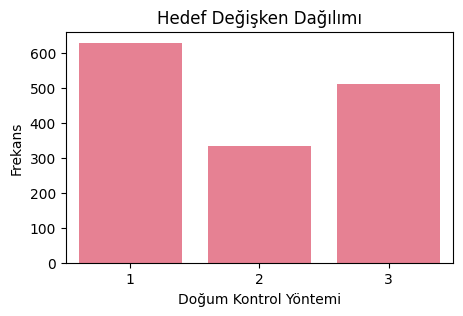

In [71]:
# Hedef değişken dağılımı
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x=df.iloc[:, -1])
plt.title('Hedef Değişken Dağılımı')
plt.xlabel('Doğum Kontrol Yöntemi')
plt.ylabel('Frekans')
plt.show()

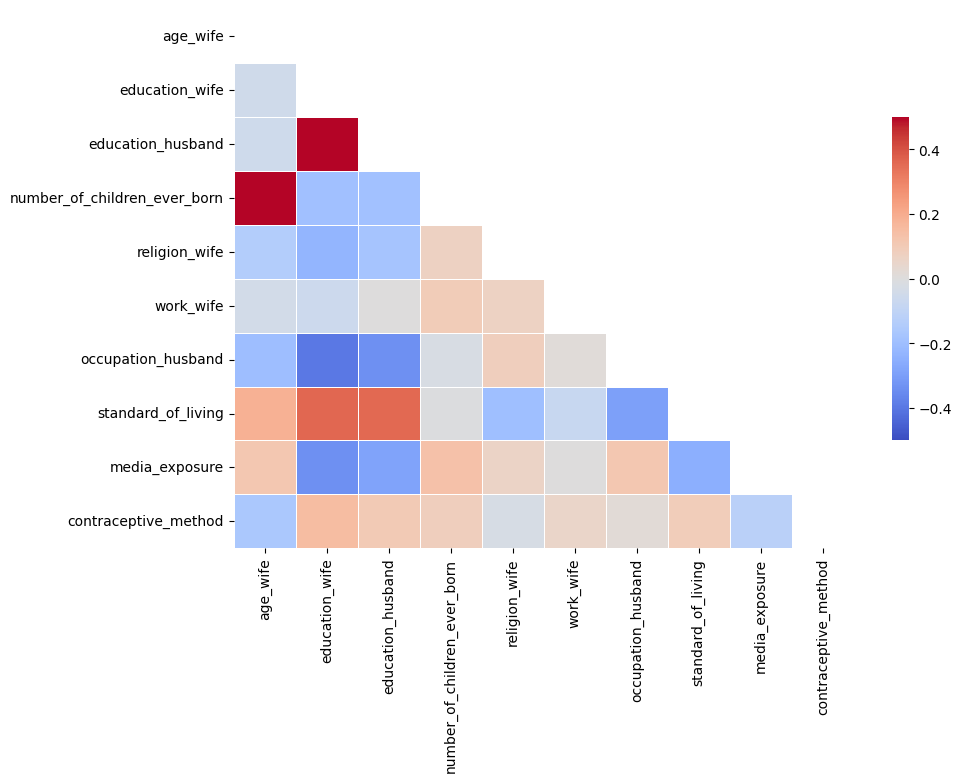

In [72]:
dt_corr = df.corr()
dt_mask = np.zeros_like(dt_corr, dtype=np.bool)
dt_mask[np.triu_indices_from(dt_mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(dt_corr, mask=dt_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

Doğum kontrol yöntemleri arasında güçlü bir ilişki tespit edilmedi


In [73]:
df['number_of_children_ever_born'] = df['number_of_children_ever_born'].apply(lambda x: min(x, 10))

In [74]:
# 2. Model Geliştirme
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 2.1 Decision Tree Modeli
dt_params = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)
dt_cv_scores = cross_val_score(dt_best, X_train, y_train, cv=5)
print(f"\nDecision Tree CV accuracy: {dt_cv_scores.mean():.4f} (+/- {dt_cv_scores.std() * 2:.4f})")

En iyi Decision Tree parametreleri: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Decision Tree CV accuracy: 0.5493 (+/- 0.0621)


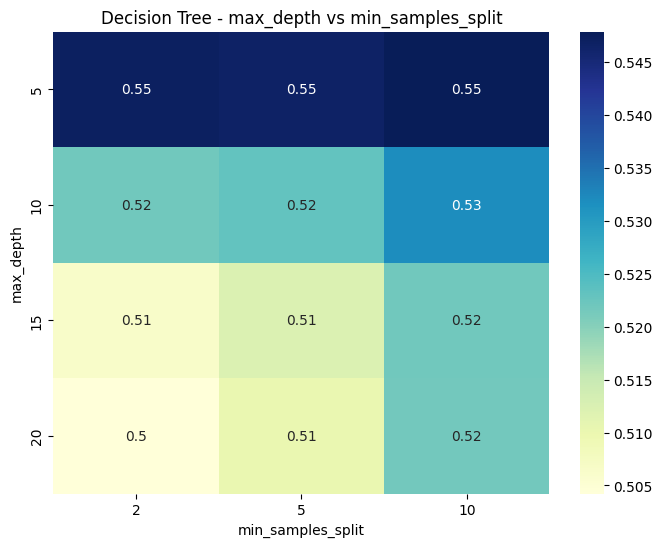

In [77]:
results = pd.DataFrame(dt_grid.cv_results_)

pivot_table = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title("Decision Tree - max_depth vs min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.show()

In [92]:
# 2.2 Random Forest Modeli
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5)
print(f"\nRandom Forest CV accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")


Random Forest CV accuracy: 0.5628 (+/- 0.0651)


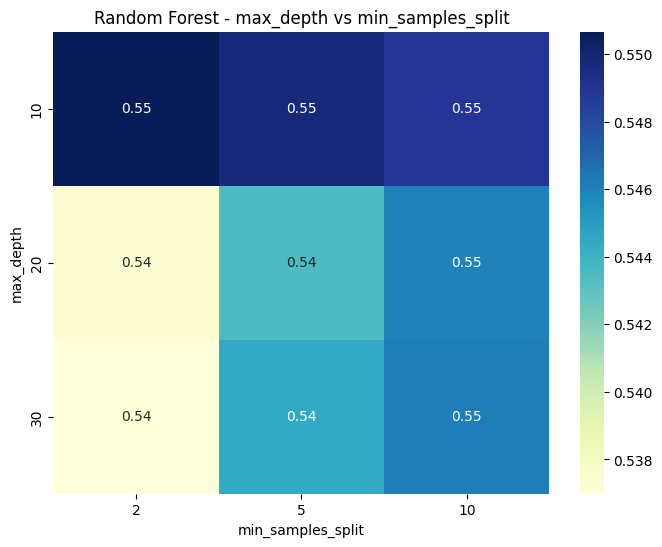

In [93]:
results = pd.DataFrame(rf_grid.cv_results_)

pivot_table = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title("Random Forest - max_depth vs min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.show()


In [100]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f"\n{model_name} Değerlendirme Sonuçları:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    class_labels = [1, 2, 3]
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Karmaşıklık Matrisi')
    plt.ylabel('Gerçek Değerler')
    plt.xlabel('Tahmin Edilen Değerler')
    plt.show()

    # ROC Curve
    class_labels = np.unique(y_test)
    n_classes = len(class_labels)
    y_test_bin = label_binarize(y_test, classes=class_labels)

    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Sınıf {class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Eğrisi')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, precision, recall, f1


Decision Tree Değerlendirme Sonuçları:
Accuracy: 0.5932
Precision: 0.5935
Recall: 0.5932
F1-score: 0.5893

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           1       0.67      0.65      0.66       126
           2       0.52      0.39      0.44        67
           3       0.54      0.66      0.60       102

    accuracy                           0.59       295
   macro avg       0.58      0.57      0.57       295
weighted avg       0.59      0.59      0.59       295



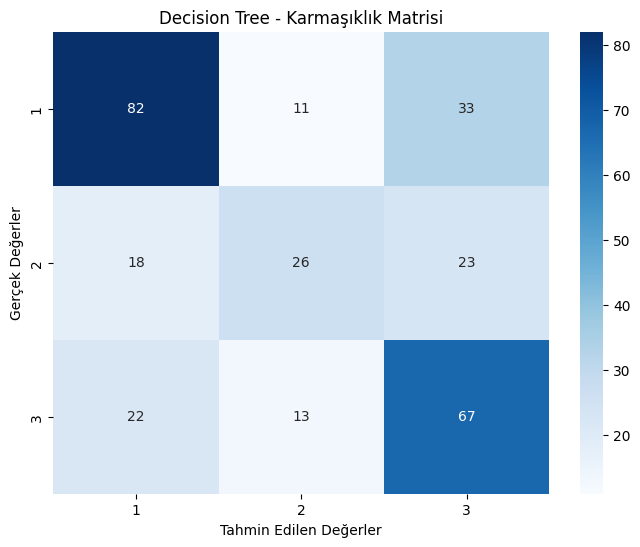

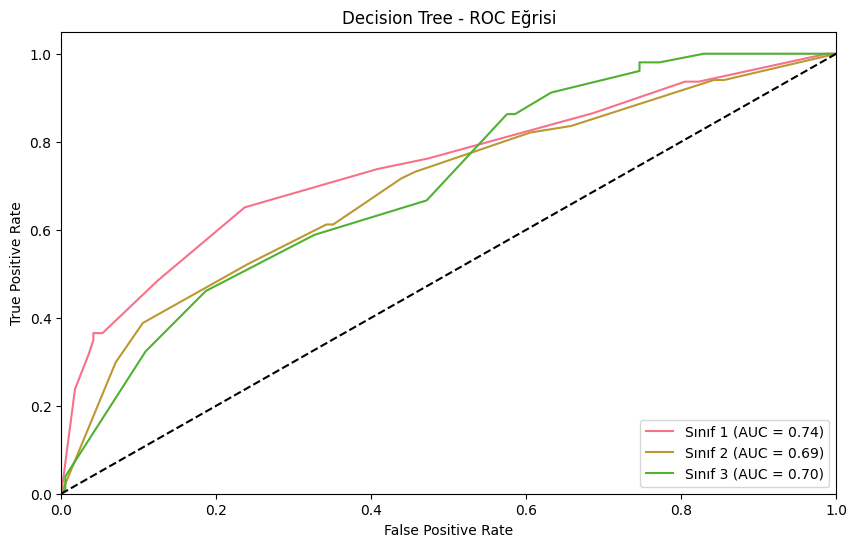


Random Forest Değerlendirme Sonuçları:
Accuracy: 0.5627
Precision: 0.5848
Recall: 0.5627
F1-score: 0.5675

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           1       0.72      0.56      0.63       126
           2       0.43      0.48      0.45        67
           3       0.51      0.62      0.56       102

    accuracy                           0.56       295
   macro avg       0.56      0.55      0.55       295
weighted avg       0.58      0.56      0.57       295



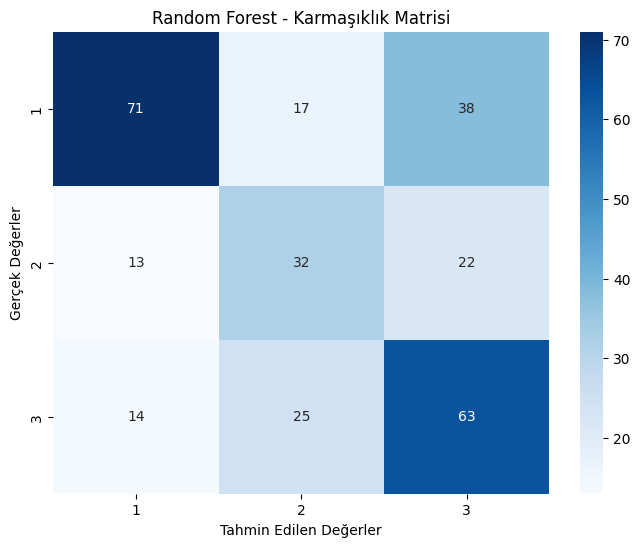

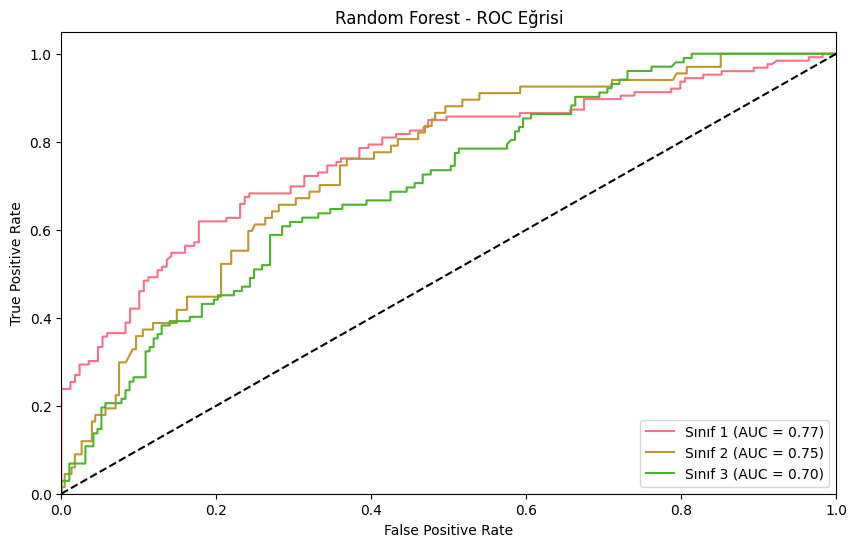

In [101]:
dt_metrics = evaluate_model(dt_best, X_test, y_test, "Decision Tree")
rf_metrics = evaluate_model(rf_best, X_test, y_test, "Random Forest")

In [83]:
# 3.2 Model Karşılaştırması
models = {
    'Decision Tree': dt_best,
    'Random Forest': rf_best
}

In [84]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    cv_scores[name] = scores

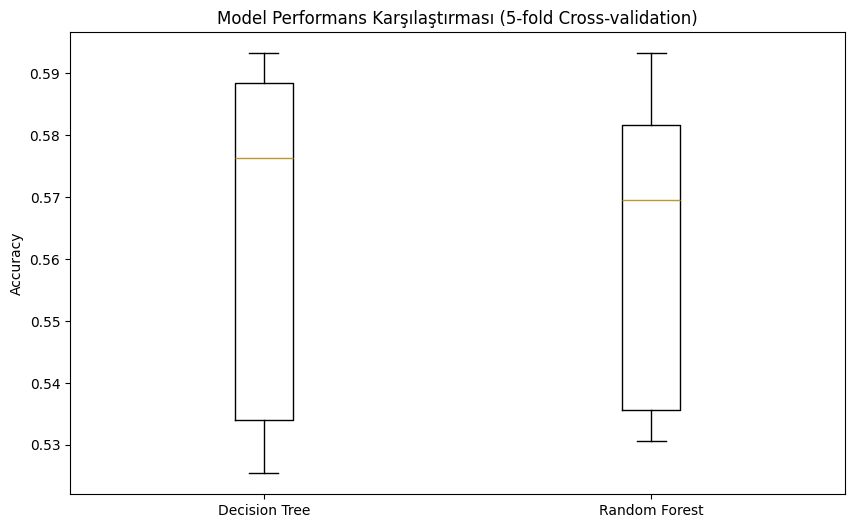

In [85]:
plt.figure(figsize=(10, 6))
plt.boxplot([cv_scores[name] for name in cv_scores.keys()], labels=cv_scores.keys())
plt.title('Model Performans Karşılaştırması (5-fold Cross-validation)')
plt.ylabel('Accuracy')
plt.show()